In [1]:
%matplotlib inline

from typing import *
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import functools
import math
import random


from collections import namedtuple
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn, optim
import torch.nn.functional as F
import torch
import functools
import os

In [2]:
lr_sm = [1e-5, 3e-5, 5e-5, 8e-5, 1e-4, 3e-4, 5e-4, 8e-4, 1e-3, 3e-3, 5e-3, 8e-3]
lr_lg = [1e-2, 3e-2, 5e-2, 8e-2, 1e-1, 3e-1, 5e-1, 8e-1, 1]
lrs = lr_sm + lr_lg

import sys
import importlib
if '241018_muon_renorm' in sys.modules:
    importlib.reload(sys.modules['241018_muon_renorm'])

muon_renorm = __import__('241018_muon_renorm')
OPTIM_MAP = muon_renorm.OPTIM_MAP
make_model = muon_renorm.make_model

optims = list(OPTIM_MAP.keys())

In [9]:
OPTIM_MAP['muon_post_ns_nesterov']

(functools.partial(<class '241018_muon_renorm.Muon'>, momentum_kind='post_ns_nesterov', norm_kind='rms_exact'),
 'muon w/ post-ns nesterov-type update\n$\\text{grad}^0_i := \\text{NS}(\\text{grad}_i)$\n$\\text{momentum}^0_i := \\text{nesterov}(\\text{grad}^0_i)$\n$\\Delta W_i := \\frac{\\text{momentum}^0_i}{||\\text{momentum}^0_i||_\\text{rms}}$')

In [5]:
del OPTIM_MAP['shampoo_precond50']
optims = list(OPTIM_MAP.keys())


In [6]:
train_results = {k: torch.empty(len(lrs), 101) for k in optims}
eval_results = {k: torch.empty(len(lrs), 101) for k in optims}

from tqdm.auto import tqdm

for ii, lr in tqdm(enumerate(lrs), total=len(lrs)):
    for optim_type in optims:
        if optim_type == 'muon':
            res = torch.load(f'241018_300steps_bzs2048/orth_muon_norm_rms_target_unit_lr{lr:g}_seed0.pth', weights_only=True, map_location='cpu')
        else:
            res = torch.load(f'241018_300steps_bzs2048/orth_{optim_type}_lr{lr:g}_seed0.pth', weights_only=True, map_location='cpu')
        train_results[optim_type][ii].copy_(torch.as_tensor(res['train_accs']))
        eval_results[optim_type][ii].copy_(torch.as_tensor(res['eval_accs']))




  0%|          | 0/21 [00:00<?, ?it/s]

In [20]:
len(optims) * len(lrs)

1722

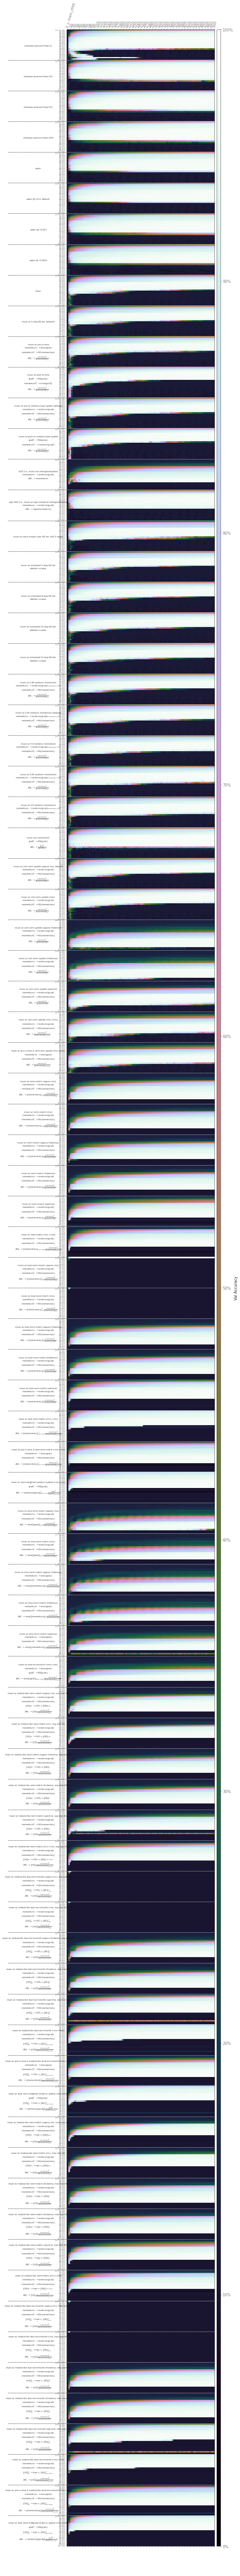

In [27]:

mat_accs = torch.stack([eval_results[optim] for optim in optims])

plt.close('all')
fig, (axem, ax) = plt.subplots(1, 2, figsize=(15, len(optims) * len(lrs) * 0.1), dpi=50, width_ratios=[0.2, 0.9])
axem.axis('off')

mat = ax.matshow(mat_accs.flatten(0, 1), vmin=0, vmax=1, cmap='cubehelix')  # use a cmap that shows changes on higher values
cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.016, ax.get_position().y1-ax.get_position().y0])
cb = fig.colorbar(mat, cax=cax, ticks=torch.linspace(0, 1, 11))
cb.ax.tick_params(labelsize=14)
# set tick labels to use percentage format
cb.ax.set_yticklabels([f'{x:.0%}' for x in cb.ax.get_yticks()], alpha=0.5)
# add cab label
cb.ax.set_ylabel('Val Accuracy', fontsize=14, color='black', alpha=0.85)

for ii in range(1, mat_accs.shape[0]):
    ax.axhline(ii * mat_accs.shape[1] - 0.5, xmin=0, color='white', linestyle='--', alpha=1, lw=1, clip_on = False)
    ax.axhline(ii * mat_accs.shape[1] - 0.5, xmin=-0.4, xmax=0, color='black', linestyle='--', alpha=1, lw=1, clip_on = False)


# add y tick labels
ax.set_yticks(range(mat_accs.shape[1] * len(optims)))
yticklabels = [f'{lr:.0e}' for lr in lrs]
yticklabels[0] = 'lr=' + yticklabels[0]
yticklabels = yticklabels * len(optims)
ax.set_yticklabels(
    yticklabels, fontsize=6.5, color='black', alpha=0.5
)

for i, optim_type in enumerate(optims):
    desc = OPTIM_MAP[optim_type][1]
    ax.text(-40, (i + 0.5) * mat_accs.shape[1], desc, ha='center', va='center', fontsize=10, color='black', alpha=0.75)

# add x tick labels
ax.set_xticks(range(0, mat_accs.shape[-1], 2))
ax.set_xticklabels(
    [
        {0: '0 = train_step'}.get(x, 5 * x)
        for x in range(0, mat_accs.shape[-1], 2)
    ], fontsize=6.5, color='black', alpha=0.5, rotation=75, ha='left', va='center', rotation_mode='anchor',
)

# fig.tight_layout()

plt.show()